In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.layers import *
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix

## Data Preparation

In [13]:
df = pd.read_csv('preprocessed_data.csv', )

In [14]:
df.head()

,text,label
0,feel really helpless heavy hearted,4
1,ive enjoy able slouch relax unwind frankly nee...,0
2,give internship dmrg feel distraught,4
3,dont know feel lose,0
4,kindergarten teacher thoroughly weary job take...,4


In [15]:
#train test split
X = df['text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.astype(str)
X_test = X_test.astype(str)

In [16]:
#Tokenization of text data
tokenizer = Tokenizer(num_words = 50000)
tokenizer.fit_on_texts(X_train)
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)

In [17]:
length = max(len(tokens) for tokens in X_train_sequence)
print(length)

79


In [18]:
X_train = pad_sequences(X_train_sequence, maxlen=length)
X_test = pad_sequences(X_test_sequence, maxlen=length)

print('X train padded')
print(X_train)
print('X test padded')
print(X_test)

X train padded
[[   0    0    0 ...  485 8280  954]
 [   0    0    0 ...  219  715   13]
 [   0    0    0 ... 1758  247 5851]
 ...
 [   0    0    0 ...    0    1  603]
 [   0    0    0 ...  247 5310  648]
 [   0    0    0 ...    1  177 1611]]
X test padded
[[   0    0    0 ...  571   15  632]
 [   0    0    0 ... 7456 3204  748]
 [   0    0    0 ...  722 2228  148]
 ...
 [   0    0    0 ...    1  517 2161]
 [   0    0    0 ...    1 1094  420]
 [   0    0    0 ... 1088 8458   24]]


In [19]:
input_size = np.max(X_train) + 1
input_size

50000

## Model Initialization

In [26]:
model = Sequential()
    
model.add(Embedding(input_dim=input_size, output_dim=60, input_length=length))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(256, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(LayerNormalization())
model.add(Bidirectional(LSTM(64)))
model.add(LayerNormalization())
model.add(Dense(6, activation='softmax'))
    
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = keras.optimizers.Adam(),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 79, 60)            3000000   
                                                                 
 dropout_2 (Dropout)         (None, 79, 60)            0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 79, 512)           649216    
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 79, 512)           0         
                                                                 
 bidirectional_7 (Bidirecti  (None, 79, 256)           656384    
 onal)                                                           
                                                                 
 layer_normalization_4 (Lay  (None, 79, 256)          

## Model training

In [28]:
model.fit(X_train, y_train,
          epochs=5,
          batch_size=512, 
          validation_data=[X_test, y_test])

Epoch 1/5
652/652 [==============================] - 1720s 3s/step - loss: 0.4922 - accuracy: 0.8076 - val_loss: 0.1444 - val_accuracy: 0.9253
Epoch 2/5
652/652 [==============================] - 1699s 3s/step - loss: 0.1460 - accuracy: 0.9252 - val_loss: 0.1233 - val_accuracy: 0.9306
Epoch 3/5
652/652 [==============================] - 1711s 3s/step - loss: 0.1244 - accuracy: 0.9314 - val_loss: 0.1188 - val_accuracy: 0.9296
Epoch 4/5
652/652 [==============================] - 1751s 3s/step - loss: 0.1163 - accuracy: 0.9339 - val_loss: 0.1167 - val_accuracy: 0.9325
Epoch 5/5
652/652 [==============================] - 1721s 3s/step - loss: 0.1109 - accuracy: 0.9353 - val_loss: 0.1161 - val_accuracy: 0.9323


In [29]:
losses = pd.DataFrame(model.history.history)

<Axes: >

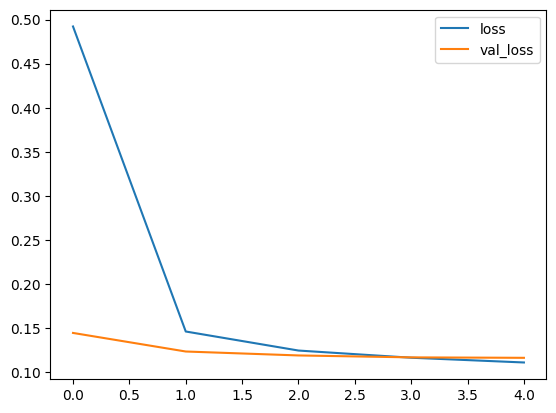

In [30]:
losses[['loss', 'val_loss']].plot()

In [31]:
predict = model.predict(X_test)
classes_x = np.argmax(predict, axis=1)

2606/2606 [==============================] - 240s 91ms/step


In [32]:
confusion_matrix(y_test, classes_x)

array([[23713,    81,    32,    70,   291,    14],
       [   72, 25674,  2047,    69,    44,   258],
       [   56,   208,  6621,    27,    11,     6],
       [  608,    61,     6, 10434,   331,     1],
       [  220,    52,     7,   200,  9101,    14],
       [   22,     8,     3,     1,   826,  2173]], dtype=int64)

In [33]:
print(classification_report(y_test, classes_x))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97     24201
           1       0.98      0.91      0.95     28164
           2       0.76      0.96      0.85      6929
           3       0.97      0.91      0.94     11441
           4       0.86      0.95      0.90      9594
           5       0.88      0.72      0.79      3033

    accuracy                           0.93     83362
   macro avg       0.90      0.90      0.90     83362
weighted avg       0.94      0.93      0.93     83362



In [34]:
model.save('model.keras')